# Build Visualization

In [1]:
import os
import glob

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from sunpy.map import Map,CompositeMap
from astropy.coordinates import SkyCoord
import yt

import synthesizAR

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/nsci_image_contest/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self

Define cropped region.

In [3]:
lc = (-300*u.arcsec,-200*u.arcsec)
rc = (350*u.arcsec,350*u.arcsec)

Prepare the full resolution AIA map

In [4]:
hmi_map = Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits').rotate()
bottom_left = SkyCoord(*lc,frame=hmi_map.coordinate_frame)
top_right = SkyCoord(*rc,frame=hmi_map.coordinate_frame)
hmi_map = hmi_map.submap(bottom_left,top_right)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


Collect simulated maps.

In [5]:
aia_maps = glob.glob('/storage-home/w/wtb2/data/nsci_image_contest/SDO_AIA/*/*.fits')
map_list = []
for i in [3,0,4]:
    m = Map(aia_maps[i])
    map_list.append(Map(np.ma.masked_less_equal(m.data,30),m.meta))

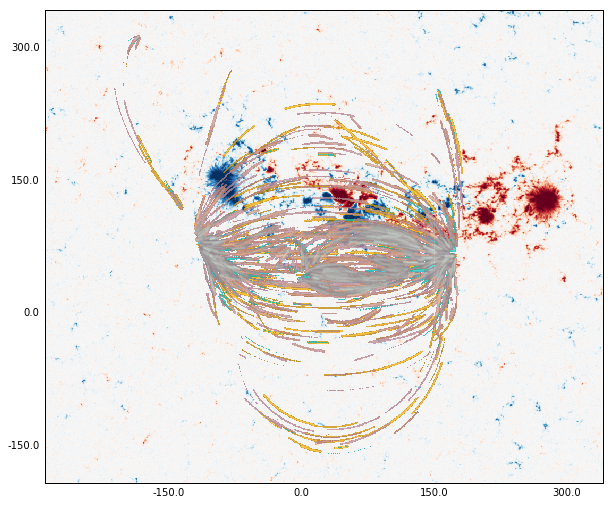

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=map_list[1])
norm = matplotlib.colors.LogNorm(vmin=0.5,vmax=5e3)
hmi_map.plot(axes=ax,
            norm=matplotlib.colors.SymLogNorm(200,vmin=-1000,vmax=1000),
            title=False,
            annotate=False,
            cmap=plt.get_cmap('RdBu'))
im1 = map_list[0].plot(axes=ax,norm=norm,annotate=False,title=False)
im2 = map_list[1].plot(axes=ax,norm=norm,annotate=False,title=False)
im3 = map_list[2].plot(axes=ax,norm=norm,annotate=False,title=False)
im1.set_alpha(0.75)
im2.set_alpha(0.75)
im3.set_alpha(0.75)
#for stream, _ in field.streamlines[::100]:
#    ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
#            field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
#            alpha=0.1, color='k', transform=ax.get_transform('world'))

Build base with fieldlines and underlying magnetogram.

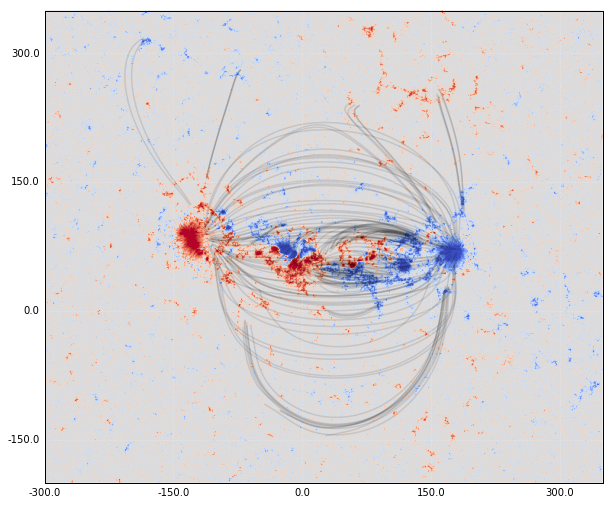

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=hmi_map)
norm = matplotlib.colors.LogNorm(vmin=0.5,vmax=5e3)
hmi_map.plot(axes=ax,
            norm=matplotlib.colors.SymLogNorm(100,vmin=-1000,vmax=1000),
            title=False,
            annotate=False,
            cmap=plt.get_cmap('coolwarm'))
for stream, _ in field.streamlines[::50]:
    ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.1, color='k', transform=ax.get_transform('world'))
#ax.axis('off')
lon = ax.coords[0]
lat = ax.coords[1]
#lon.set_ticklabel_visible(False)
#lat.set_ticklabel_visible(False)
#lon.set_ticks_visible(False)
#lat.set_ticks_visible(False)

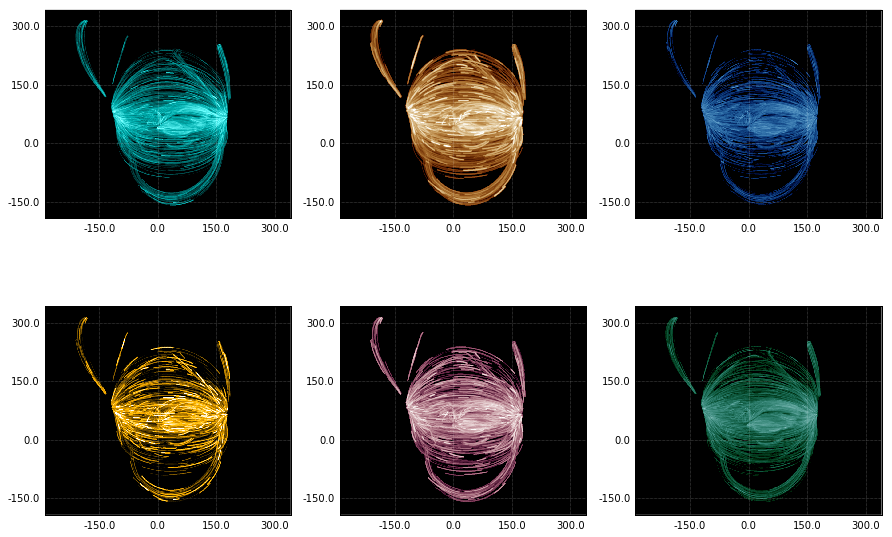

In [8]:
fig = plt.figure(figsize=(15,10))
for i,af in enumerate(aia_maps):
    m = Map(af)
    #bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
    #top_right = SkyCoord(*rc,frame=m.coordinate_frame)
    #m = m.submap(bottom_left,top_right)
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,annotate=False,title=False,
           norm=matplotlib.colors.SymLogNorm(1e-2,vmin=1,vmax=1e3))

## Sandbox

In [10]:
test_hmi = Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits').rotate()
bottom_left = SkyCoord(*lc,frame=test_hmi.coordinate_frame)
top_right = SkyCoord(*rc,frame=test_hmi.coordinate_frame)
test_hmi = test_hmi.submap(bottom_left,top_right)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [11]:
test_aia = Map('/storage-home/w/wtb2/sunpy/data/aia_lev1_171a_2017_08_20t18_15_09_35z_image_lev1.fits')
test_aia = Map(np.ma.masked_less_equal(test_aia.data,500),test_aia.meta)
bottom_left = SkyCoord(*lc,frame=test_aia.coordinate_frame)
top_right = SkyCoord(*rc,frame=test_aia.coordinate_frame)
test_aia = test_aia.submap(bottom_left,top_right)

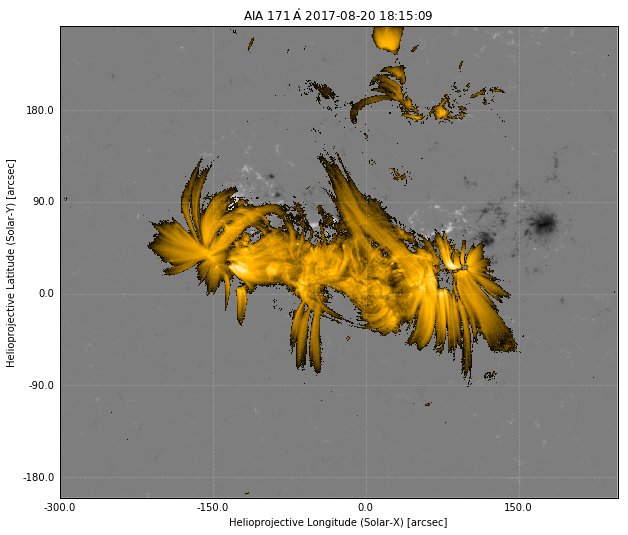

In [12]:
plt.figure(figsize=(10,10))
test_hmi.plot()
test_aia.plot()